In [18]:
import os
os.getcwd()
# os.chdir('..')
print(f'Current working directory is {os.getcwd()}')

Current working directory is c:\Users\blond\Documents\NssProjects\sleigh_the_model


In [19]:
import pandas as pd
import scripts.features as ft
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt


In [20]:
file = 'data/dataformodel.csv'
months_in_adv = 12
months_lag = 12
data = ft.load_data(file, months_in_adv)


In [21]:
features_to_lag = [
    'pce',
    'inflation',
    'unemployment_rate',
    'revolving_credit',
    'nonrevolving_credit',
    'total_credit'
]

In [22]:
data_with_lag = ft.add_lag_features(data, months_lag, features_to_lag)

subset_cols = [col for col in data_with_lag.columns if ('lag' in col) or (col in features_to_lag) or (col == 'pce_future')]
train_data = data_with_lag.dropna(subset=subset_cols)

X_train_columns = [col for col in train_data.columns if col not in ['date', 'pce_future', 'pce']]
X_train = train_data[X_train_columns]
y_train = train_data['pce_future']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

lasso = Lasso(alpha=0.1, max_iter=10000)
lasso.fit(X_scaled, y_train)


last_date = data_with_lag['date'].max()


forecast_months = 9
end_forecast_date = last_date + pd.DateOffset(months=forecast_months)

future_dates = pd.date_range(
    start=last_date + pd.DateOffset(months=1),
    end=end_forecast_date,
    freq='MS'
)

print(f"Last historical data point: {last_date}")
print(f"Forecasting up to: {end_forecast_date}")
print(f"Future dates for prediction: {future_dates.strftime('%Y-%m-%d').tolist()}")


current_row = data_with_lag.sort_values('date').iloc[-1].copy()
pred_rows = []

for forecast_date in future_dates:
    for feature in features_to_lag:
        for i in range(months_lag, 1, -1):
            current_row[f"{feature}_lag_{i}"] = current_row[f"{feature}_lag_{i-1}"]
        current_row[f"{feature}_lag_1"] = current_row[feature]

    current_row['date'] = forecast_date

    predict_input = pd.DataFrame([current_row[X_train_columns]])
    predict_input_scaled = scaler.transform(predict_input)
    pred = lasso.predict(predict_input_scaled)[0]

    pred_rows.append({
        'Prediction_Date': forecast_date,
        'Predicted_PCE': pred
    })

    current_row['pce'] = pred

prediction_results = pd.DataFrame(pred_rows)

prediction_results['Smoothed_PCE'] = prediction_results['Predicted_PCE'].rolling(window=5, min_periods=1).mean()
print("*** Future PCE Predictions ***")
print(prediction_results)


Last historical data point: 2025-04-01 00:00:00
Forecasting up to: 2026-01-01 00:00:00
Future dates for prediction: ['2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01', '2025-09-01', '2025-10-01', '2025-11-01', '2025-12-01', '2026-01-01']
*** Future PCE Predictions ***
  Prediction_Date  Predicted_PCE  Smoothed_PCE
0      2025-05-01   22166.509109  22166.509109
1      2025-06-01   23685.745425  22926.127267
2      2025-07-01   25578.912051  23810.388862
3      2025-08-01   28130.968682  24890.533817
4      2025-09-01   31493.029088  26211.032871
5      2025-10-01   35968.197988  28971.370647
6      2025-11-01   41969.393263  32628.100214
7      2025-12-01   50059.644844  37524.246773
8      2026-01-01   60948.844569  44087.821950


c:\Users\blond\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.330e+07, tolerance: 2.246e+06
  model = cd_fast.enet_coordinate_descent(


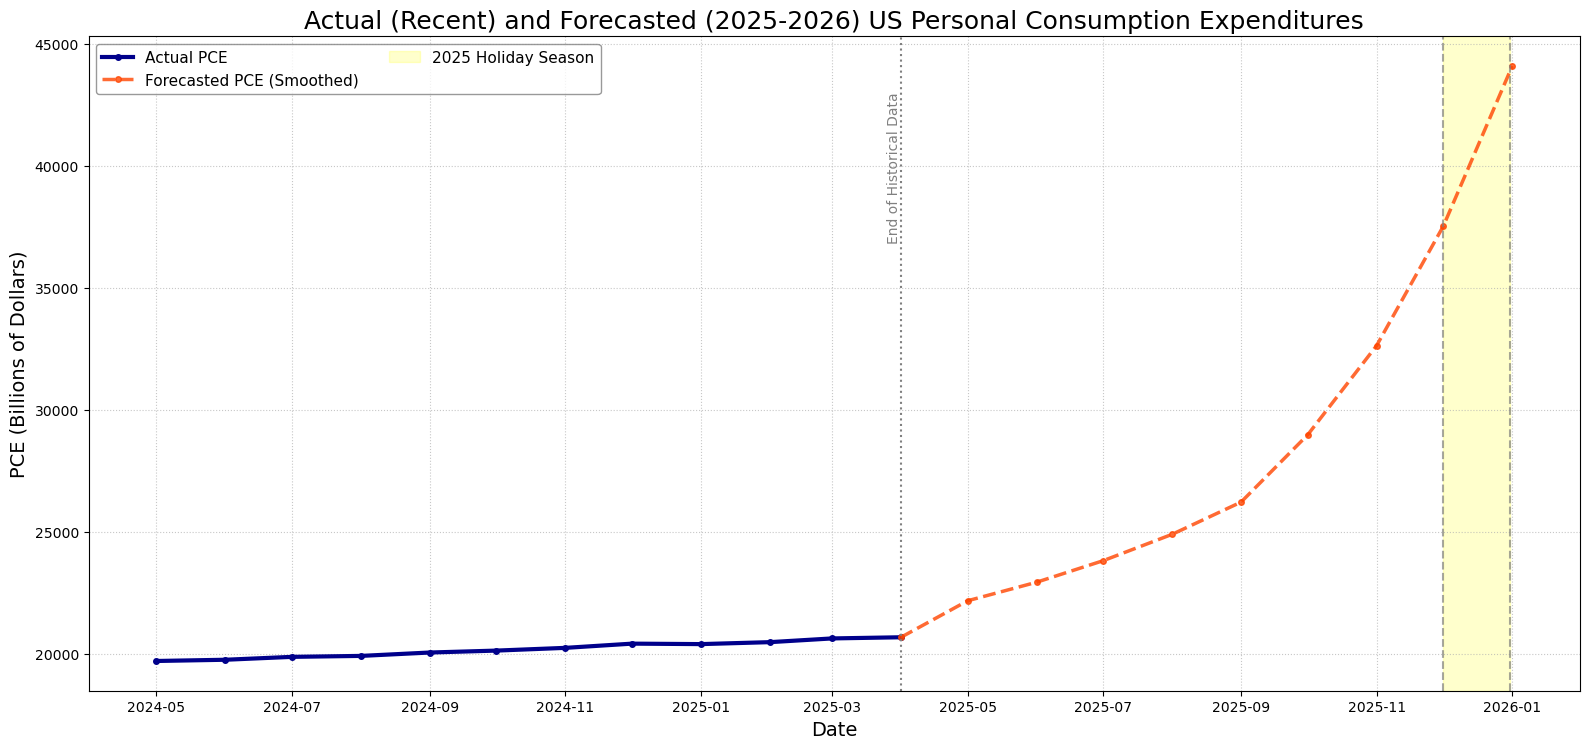

In [ ]:

plt.figure(figsize=(16, 8))

start_historical_plot_date = pd.to_datetime('2024-05-01') 
recent_actual_pce_data = data[(data['date'] >= start_historical_plot_date) &
                              (data['date'] <= data['date'].max())].copy()

forecast_pce_plot = prediction_results[['Prediction_Date', 'Smoothed_PCE']].copy()
forecast_pce_plot = forecast_pce_plot.rename(columns={'Prediction_Date': 'date', 'Smoothed_PCE': 'pce'})

last_actual_point = recent_actual_pce_data.iloc[-1].copy()

forecast_series_with_transition = pd.DataFrame({
    'date': [last_actual_point['date']] + forecast_pce_plot['date'].tolist(),
    'pce': [last_actual_point['pce']] + forecast_pce_plot['pce'].tolist()
})

plt.plot(recent_actual_pce_data['date'],
         recent_actual_pce_data['pce'],
         label='Actual PCE', color='darkblue', linewidth=3, marker='o', markersize=4) # Strong, clear line

plt.plot(forecast_series_with_transition['date'],
         forecast_series_with_transition['pce'],
         label='Forecasted PCE (Smoothed)', color='orangered', linestyle='--', linewidth=2.5, marker='o', markersize=4,
         alpha=0.8) 

ax = plt.gca() 
plt.axvline(x=data['date'].max(), color='gray', linestyle=':', linewidth=1.5)
plt.text(data['date'].max(), ax.get_ylim()[1] * 0.95, 'End of Historical Data',
         rotation=90, va='top', ha='right', color='gray', fontsize=10) # Place label explicitly

holiday_start_2025 = pd.to_datetime('2025-12-01')
holiday_end_2025 = pd.to_datetime('2025-12-31')

if forecast_pce_plot['date'].max() >= holiday_end_2025 and forecast_pce_plot['date'].min() <= holiday_start_2025:
    plt.axvspan(holiday_start_2025, holiday_end_2025, color='yellow', alpha=0.2, label='2025 Holiday Season')
    plt.axvline(holiday_start_2025, color='gray', linestyle='--', alpha=0.7)
    plt.axvline(holiday_end_2025, color='gray', linestyle='--', alpha=0.7)


plt.title('Actual (Recent) and Forecasted (2025-2026) US Personal Consumption Expenditures', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('PCE (Billions of Dollars)', fontsize=14)
plt.legend(loc='upper left', ncol=2, fontsize=11, frameon=True, facecolor='white', edgecolor='gray')
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig("visuals/forecast12.png", dpi=300)
plt.savefig("visuals/forecast6.png", dpi=300)
plt.show()